# Модель для рекомендации тарифа

**Заказчик:** Оператор мобильной связи «Мегалайн».

**Входные данные:** данные о поведении клиентов, использующих определенные тарифы; предобработка уже выполнена. 

**Цель проекта:** построить модель, способную проанализировать поведение пользователей архивных тарифов и предложить один из действующих тарифов — «Смарт» или «Ультра».

**Задачи проекта:**

- построить модель для задачи классификации, которая выберет подходящий тариф;
- для оценки качества модели использовать метрику **accuracy**;
- минимально приемлемое значение **accuracy = 0.75**;
- дать рекомендации по дальнейшему развитию данного проекта.

## Начальная подготовка

### Импорты

In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

import os
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

### Вспомогательные функции 

In [2]:
#--------------------------------------------------------------------

def custom_read_csv(path_local, separator=','):
    """
    чтение датасета:
      сначала из локального хранилища;
      при неудаче — из удаленного хранилища (добавление слеша – особенности синтаксиса линукса или как там его)
    """

    path_remote = '/' + path_local

    if os.path.exists(path_local):
        return pd.read_csv(path_local, sep=separator)

    elif os.path.exists(path_remote):
        return pd.read_csv(path_remote, sep=separator)

    else:
        print('Ошибка')


#--------------------------------------------------------------------

def df_name(df):
    """
    определение имени таблицы
    """
    return [name for name in globals() if globals()[name] is df][0]


#--------------------------------------------------------------------

def basic_info(df: pd.DataFrame, sample_type='sample', qnty=5):
    """
    первичная информация о таблице
    """
    
    # заголовок (имя исследуемого датафрейма)
    
    print(f'\n\nдатафрейм {f.BOLD}{df_name(df)}{f.END}', '≋'*30)


    # метод info()
    
    print('\n\n--- метод info() ---\n')
    print(df.info())

    
    # несколько случайных записей
    
    print(f'\n\n--- метод {sample_type}({qnty}) ---' + '\n')
    
    if sample_type == 'sample':
        display(df.sample(qnty))
    elif sample_type == 'head':
        display(df.head(qnty))
    elif sample_type == 'tail':
        display(df.tail(qnty))
    else:
        print(f'{sample_type} – недопустимое значение параметра "sample_type" ')
    
    
    # метод describe()
    
    print('\n\n--- метод describe() ---\n')
    
    try:
        display(df.describe(include=np.number))
    except ValueError:
        pass

    try:
        display(df.describe(exclude=np.number))
    except ValueError:
        pass

### Вспомогательные элементы для оформления

In [3]:
#--------------------------------------------------------------------------
# пустые строки для свободного пространства при выводе на экран

def space(num=1):
    print('\n' * num)


#--------------------------------------------------------------------------
# выделение в тексте

class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

### Настройки

In [4]:
# стиль графиков

sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plot_dpi = 150                                    # dpi для рендеринга графиков
colors = ['darkcyan', 'orange', 'tomato']         # цвета для графиков


# внешний вид

# pd.options.display.colheader_justify = 'left'
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

pd.options.display.float_format = '{:.3f}'.format
# pd.options.display.precision = 7
# pandas.options.mode.use_inf_as_na = True

warnings.filterwarnings('ignore')


# константы

RS = 66                                           # константа длля параметра random_state

## Чтение и проверка входных данных

Каждый объект в наборе данных – это информация о поведении одного пользователя за месяц.

`сalls` — количество звонков,  
`minutes` — суммарная длительность звонков в минутах,  
`messages` — количество sms-сообщений,  
`mb_used` — израсходованный интернет-трафик в Мб,  
`is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

### Чтение данных

In [5]:
data = custom_read_csv('datasets/users_behavior.csv')  # данные о поведении пользователей

### Первичная информация о данных

In [6]:
basic_info(data)



датафрейм data ≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋


--- метод info() ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None


--- метод sample(5) ---



,calls,minutes,messages,mb_used,is_ultra
1304,67.000,509.290,49.000,21074.820,0
2376,55.000,397.370,41.000,17494.520,0
2995,80.000,590.220,0.000,30671.000,1
462,85.000,540.200,57.000,17836.840,1
1594,27.000,142.230,48.000,19480.660,0




--- метод describe() ---



,calls,minutes,messages,mb_used,is_ultra
count,3214.000,3214.000,3214.000,3214.000,3214.000
mean,63.039,438.209,38.281,17207.674,0.306
std,33.236,234.570,36.148,7570.968,0.461
min,0.000,0.000,0.000,0.000,0.000
25%,40.000,274.575,9.000,12491.903,0.000
50%,62.000,430.600,30.000,16943.235,0.000
75%,82.000,571.927,57.000,21424.700,1.000
max,244.000,1632.060,224.000,49745.730,1.000


> Тариф "Ультра" у 30.6% пользователей, тариф "Смарт" — у 69.4% пользователей.
>
> Если в качестве прогноза выдавать постоянное значение, рекомендующее тариф "Смарт", метрика `accuracy` такого прогноза составит `0.694`. Это и будет минимальное "адекватное" значение метрики `accuracy`.

### Распределение признаков для пользователей разных тарифов

Для понимания различий между пользователями двух тарифов.

#### Графики распределений

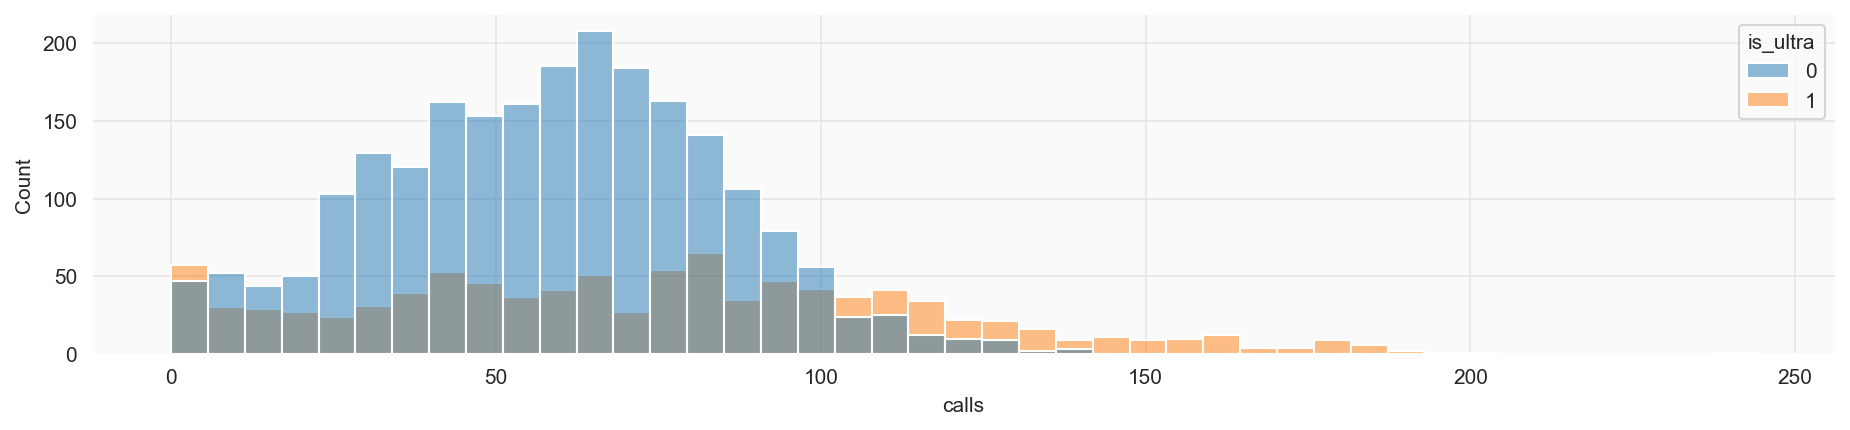

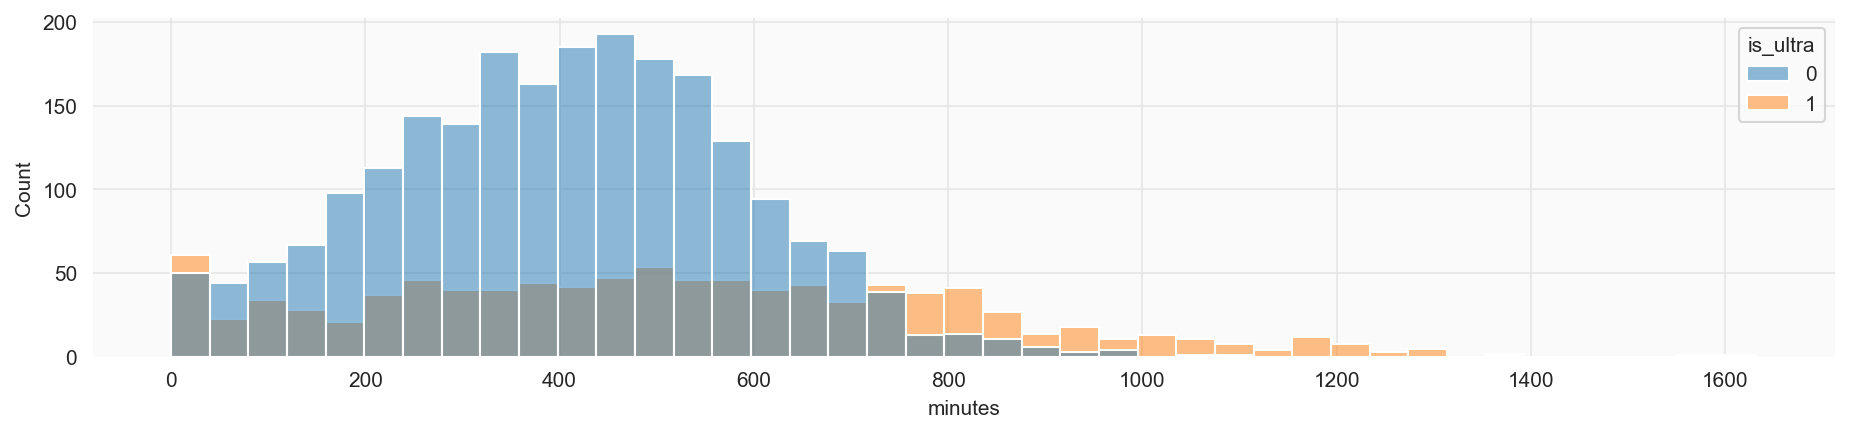

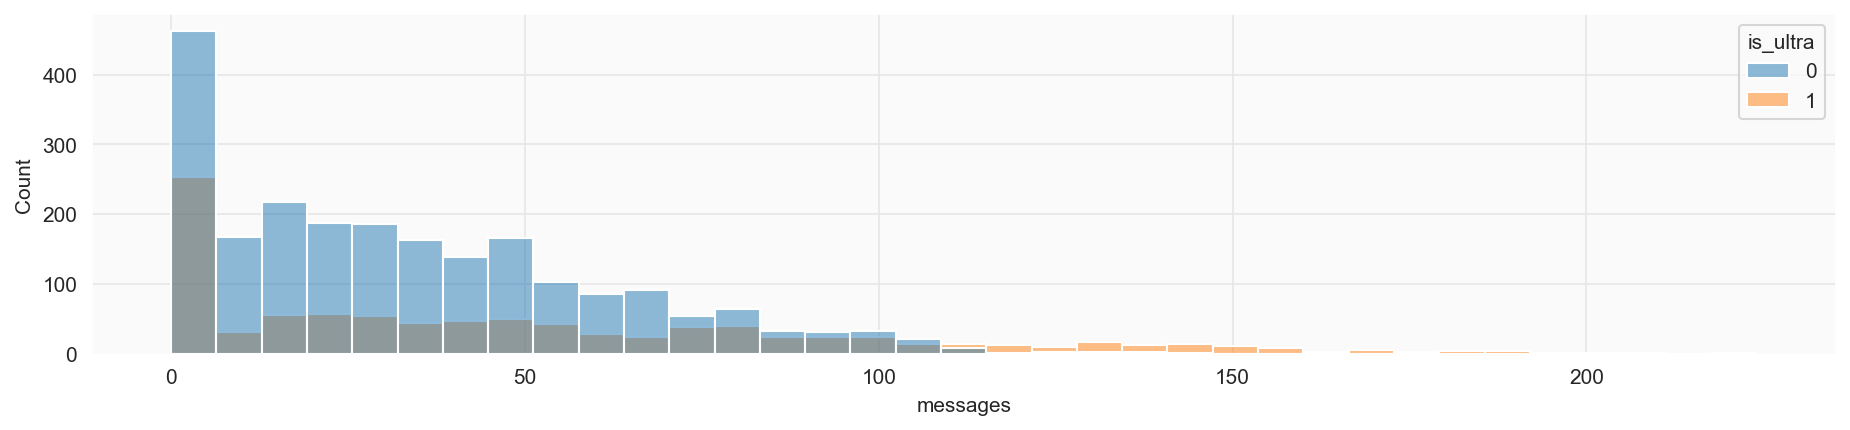

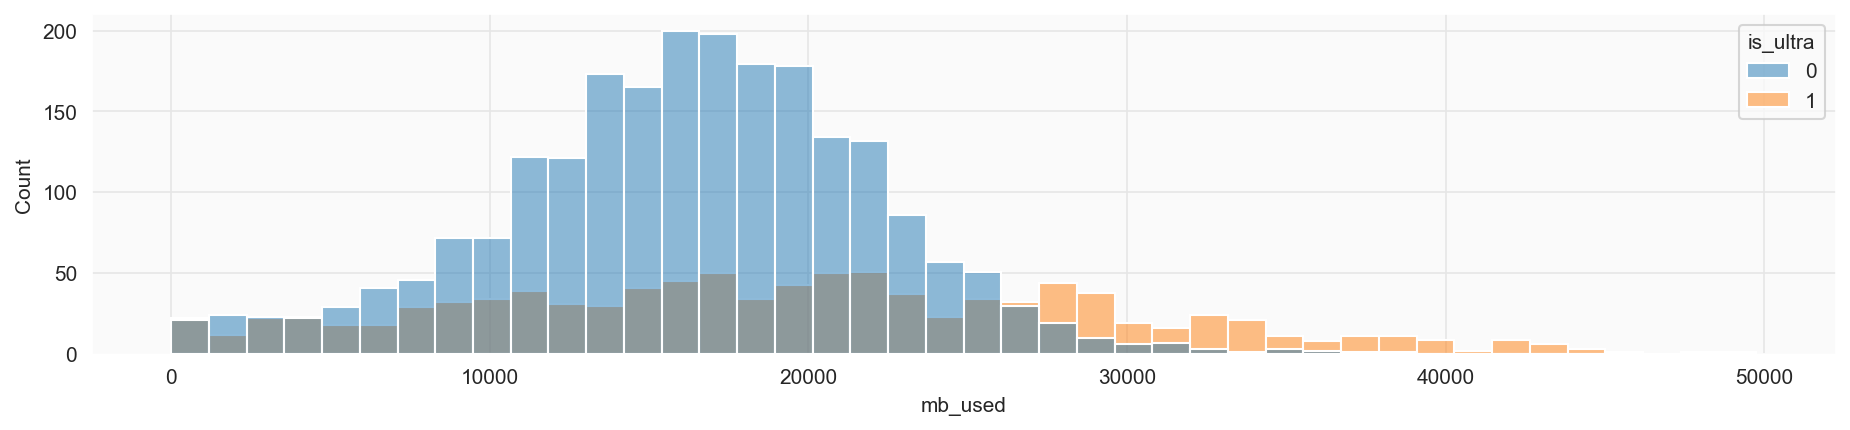

In [7]:
for column in data.drop('is_ultra', axis=1).columns:
    fig, ax = plt.subplots(figsize=(15,3), dpi=plot_dpi)
    sns.histplot(x=data[column], hue=data.is_ultra);

> За исключением `messages` распределения признаков "Смарт"-клиентов близко к нормальному, в то время как у "Ультра"-клиентов оно растянуто во всем диапазоне значений.
> 
> Часть "Ультра"-клиентов потребляет ресурсов больше, чем основная масса "Смарт"-клиентов. Но в целом трудно описать характерный портрет "Ультра"-клиента.

#### Статистики распределений

In [8]:
(
    data
    .groupby('is_ultra')
    .describe()
    .T
    .reset_index()
    .rename(columns={'level_0':'feature', 'level_1':'stat', 0:'smart', 1:'ultra'})
    .query('stat.isin(["mean","50%","std"])')
)

is_ultra,feature,stat,smart,ultra
1,calls,mean,58.463,73.393
2,calls,std,25.940,43.917
5,calls,50%,60.000,74.000
9,minutes,mean,405.943,511.225
10,minutes,std,184.513,308.031
13,minutes,50%,410.560,502.550
17,messages,mean,33.384,49.363
18,messages,std,28.228,47.804
21,messages,50%,28.000,38.000
25,mb_used,mean,16208.467,19468.823


> Для распределений признаков "Ультра"-пользователей характерны более высокое среднее значение и медиана, а также существенно более высокое стандартное отклонение.

### Корреляция признаков с целевой переменной

In [9]:
data.corr().is_ultra.to_frame().T.drop('is_ultra', axis=1)

,calls,minutes,messages,mb_used
is_ultra,0.207,0.207,0.204,0.199


> Вск признаки обладают примерно одинаковой слабой корреляцией с целевой переменной.

### Попарные распределения признаков

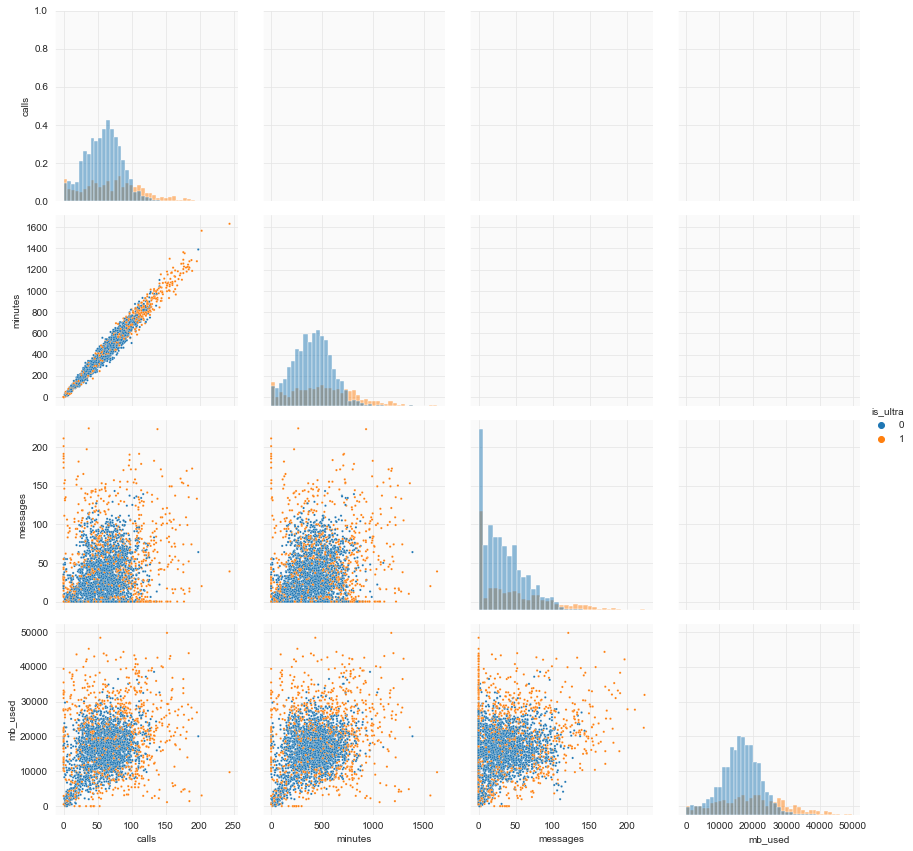

In [10]:
(
    sns.PairGrid(data, hue='is_ultra', height=3, hue_kws={"alpha": [1,1]})
    .map_diag(sns.histplot)
    .map_lower(sns.scatterplot, s=5)
    .add_legend()
);

> Ни по одному из признаков нет значимого разделения на классы.

> Класс "Ультра" хорошо выделяется в области больших значений по всем признакам.

> Попарное сочетание признака `mb_used` с другими признаками дает разделение классов несколько лучше в области низких значений. Возможно, это поможет модели.

## Подготовка данных для моделей

### Выделение признаков и целевой переменной

In [11]:
X = data.drop('is_ultra', axis=1)
Y = data.is_ultra

### Разделение на обучающую и тестовую выборки

Долее при обучении моделей будет использована кроссвалидация, поэтому на данном этапе валидационная выборка не создается.

In [12]:
# разделение на обучающую_валидационную и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RS)

# проверка размеров выборок
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((2571, 4), (2571,), (643, 4), (643,))

## Обучение моделей

### Подготовка пайплайнов моделей

In [13]:
pipeline_DTC = Pipeline([('dtc', DecisionTreeClassifier(random_state=RS))])
pipeline_RFC = Pipeline([('rfc', RandomForestClassifier(random_state=RS))])
pipeline_ETC = Pipeline([('etc', ExtraTreesClassifier(random_state=RS))])
pipeline_GBC = Pipeline([('gbc', GradientBoostingClassifier(random_state=RS))])
pipeline_LgR = Pipeline([('lgr', LogisticRegression(random_state=RS))])

### Подготовка сеток гиперпараметров

In [14]:
params_DTC = {
              'dtc__max_depth': range(2,20),
             }

params_RFC = {
              'rfc__max_depth': range(8,11),
              'rfc__n_estimators': range(55,60),
              'rfc__min_samples_leaf': [2],
             }

params_ETC = {
              'etc__max_depth': range(9,14),
              'etc__n_estimators': range(55,60),
             }

params_GBC = {
              'gbc__max_depth': range(2,5),
              'gbc__n_estimators': range(20,25),
              'gbc__learning_rate': np.linspace(0,1,20),
             }

params_LgR = {
              'lgr__max_iter': range(10,1000,10),
             }

### Объединение всех данных о моделях в датафрейм

Для удобства контроля и обработки результата.

In [15]:
models = pd.DataFrame(
                      data={'name': ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier',
                                     'GradientBoostingClassifier', 'LogisticRegression'],
                            'pipeline': [pipeline_DTC, pipeline_RFC, pipeline_ETC, pipeline_GBC, pipeline_LgR],
                            'params': [params_DTC, params_RFC, params_ETC, params_GBC, params_LgR],
                            'best_params': None
                           },
                     )
models

,name,pipeline,params,best_params
0,DecisionTreeClassifier,(DecisionTreeClassifier(random_state=66)),"{'dtc__max_depth': (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)}",None
1,RandomForestClassifier,(RandomForestClassifier(random_state=66)),"{'rfc__max_depth': (8, 9, 10), 'rfc__n_estimators': (55, 56, 57, 58, 59), 'rfc__min_samples_leaf...",None
2,ExtraTreesClassifier,(ExtraTreesClassifier(random_state=66)),"{'etc__max_depth': (9, 10, 11, 12, 13), 'etc__n_estimators': (55, 56, 57, 58, 59)}",None
3,GradientBoostingClassifier,(GradientBoostingClassifier(random_state=66)),"{'gbc__max_depth': (2, 3, 4), 'gbc__n_estimators': (20, 21, 22, 23, 24), 'gbc__learning_rate': [...",None
4,LogisticRegression,(LogisticRegression(random_state=66)),"{'lgr__max_iter': (10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 1...",None


### Случайный поиск по сетке гиперпараметров

Отдаю препочтение `RandomizedSearchCV` перед `GridSearchCV` из-за возможности гибко влиять на длительность процесса.  
К тому же при достаточном количестве итераций случайный поиск аналогичен полному поиску, т. е. `GridSearchCV` можно считать частным случаем `RandomizedSearchCV`.

In [16]:
%%time

for item in range(models.shape[0]):
    models.loc[item,'best_params'] = (
                                      RandomizedSearchCV(
                                                         models.loc[item,'pipeline'],
                                                         param_distributions=models.loc[item,'params'],
                                                         n_iter=100,
                                                         cv=3,
                                                         scoring='accuracy',
                                                         return_train_score=True,
                                                         n_jobs=-1,
                                                         random_state=RS,
                                                        )
                                      .fit(X_train, Y_train)
                                     )

    print(f.BOLD + models.loc[item,'name'] + f.END)
    print('Лучший результат и комбинация гиперпараметров:')
    print(f'{models.loc[item,"best_params"].best_score_:0.4f} при {models.loc[item,"best_params"].best_params_} \n')

DecisionTreeClassifier
Лучший результат и комбинация гиперпараметров:
0.7869 при {'dtc__max_depth': 3} 

RandomForestClassifier
Лучший результат и комбинация гиперпараметров:
0.8102 при {'rfc__n_estimators': 58, 'rfc__min_samples_leaf': 2, 'rfc__max_depth': 9} 

ExtraTreesClassifier
Лучший результат и комбинация гиперпараметров:
0.8102 при {'etc__n_estimators': 57, 'etc__max_depth': 11} 

GradientBoostingClassifier
Лучший результат и комбинация гиперпараметров:
0.8055 при {'gbc__n_estimators': 23, 'gbc__max_depth': 3, 'gbc__learning_rate': 0.15789473684210525} 

LogisticRegression
Лучший результат и комбинация гиперпараметров:
0.7277 при {'lgr__max_iter': 70} 

CPU times: total: 2.5 s
Wall time: 14.6 s


> Лучшие результаты у `RandomForestClassifier` и `ExtraTreesClassifier`, незначительно хуже у `GradientBoostingClassifier`.
>
> Существенно хуже `LogisticRegression` – результат лишь немного лучше минимально допустимого значения `accuracy=0.694` для этого набора данных

### Проверка моделей на тестовой выборке

In [17]:
for item in range(models.shape[0]):
    print(f.BOLD + models.loc[item,'name'] + f.END)
    print(f'Результат на тестовой выборке: {models.loc[item,"best_params"].score(X_test, Y_test):0.4f} \n')

DecisionTreeClassifier
Результат на тестовой выборке: 0.7994 

RandomForestClassifier
Результат на тестовой выборке: 0.8274 

ExtraTreesClassifier
Результат на тестовой выборке: 0.8320 

GradientBoostingClassifier
Результат на тестовой выборке: 0.8243 

LogisticRegression
Результат на тестовой выборке: 0.7683 



> На тестовой выборке все модели показали результаты выше, чем на кроссвалидации. Впрочем, это лишь случайное влияние параметра `random_state`. Во всяком случае, на тестовой выборке модели не провалились.

## Анализ лучшей модели

Оценка важности признаков для наиболее успешных моделей.

### Функция для визуализации важности признаков

In [18]:
def plot_importance(model_name, model):

    """
    Функция принимает название модели и саму обученную модель.
    Используется атрибут модели feature_importances_.
    Результат: вывод таблицы и графика важности каждого признака, использованного при обучении модели.
    """
    
    # таблица

    df = (
          pd.DataFrame({
                        'feature': X_train.columns,
                        'importance': model.feature_importances_
                       })
          .sort_values('importance', ascending=False)
         )
    
    display(df)


    # график

    fig, ax = plt.subplots(figsize=(15,2), dpi=plot_dpi)

    sns.barplot(x=df.importance, y=df.feature, color=colors[2])
    plt.title(f'{model_name}: важность признаков', fontsize=20, pad=30)
    plt.xlabel('важность', fontsize=14)
    plt.ylabel('признаки', fontsize=14)

    plt.show()

### RandomForestClassifier

#### Обучение модели с лучшей комбинацией гиперпараметров

In [19]:
best_params = models.loc[1,'best_params'].best_params_      # гиперпараметры лучшей модели RandomForestClassifier

model_RFC = (
             RandomForestClassifier(
                                    n_estimators=best_params['rfc__n_estimators'],
                                    max_depth=best_params['rfc__max_depth'],
                                    min_samples_leaf = best_params['rfc__min_samples_leaf'],
                                    random_state=RS,
                                   )
            .fit(X_train, Y_train)
           )

#### Визуализация важности признаков

,feature,importance
3,mb_used,0.365
1,minutes,0.249
0,calls,0.207
2,messages,0.179


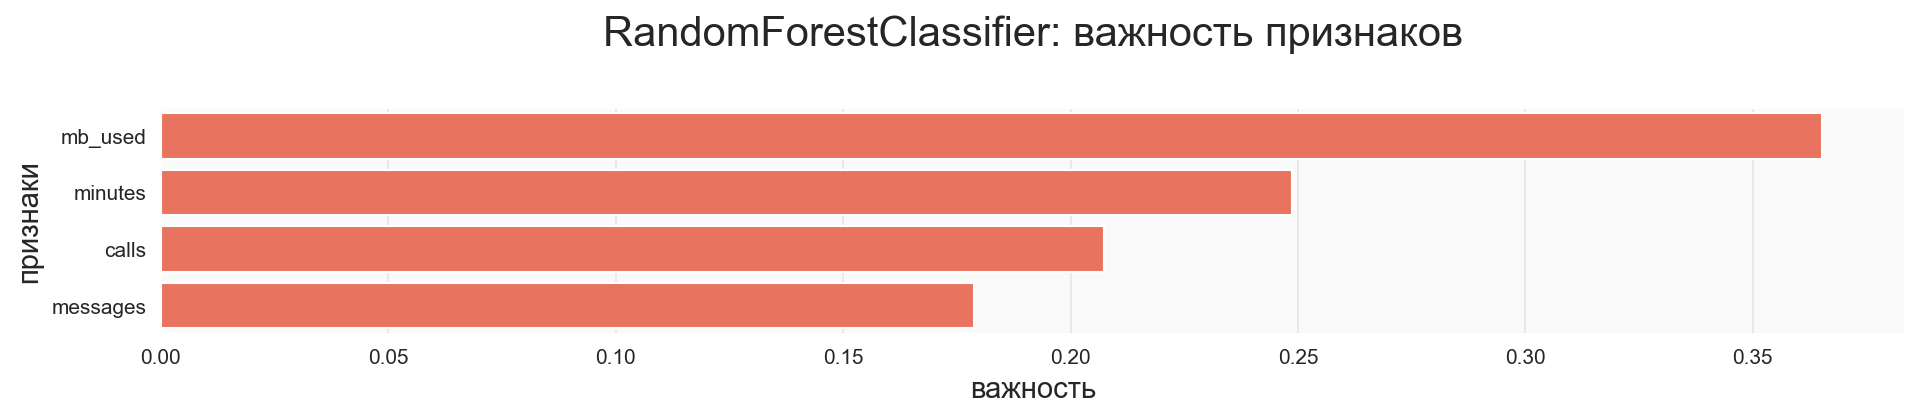

In [20]:
plot_importance('RandomForestClassifier', model_RFC)

### ExtraTreesClassifier

#### Обучение модели с лучшей комбинацией гиперпараметров

In [21]:
best_params = models.loc[2,'best_params'].best_params_      # гиперпараметры лучшей модели ExtraTreesClassifier

model_ETC = (
             RandomForestClassifier(
                                    n_estimators=best_params['etc__n_estimators'],
                                    max_depth=best_params['etc__max_depth'],
                                    random_state=RS,
                                   )
            .fit(X_train, Y_train)
           )

#### Визуализация важности признаков

,feature,importance
3,mb_used,0.356
1,minutes,0.255
0,calls,0.203
2,messages,0.185


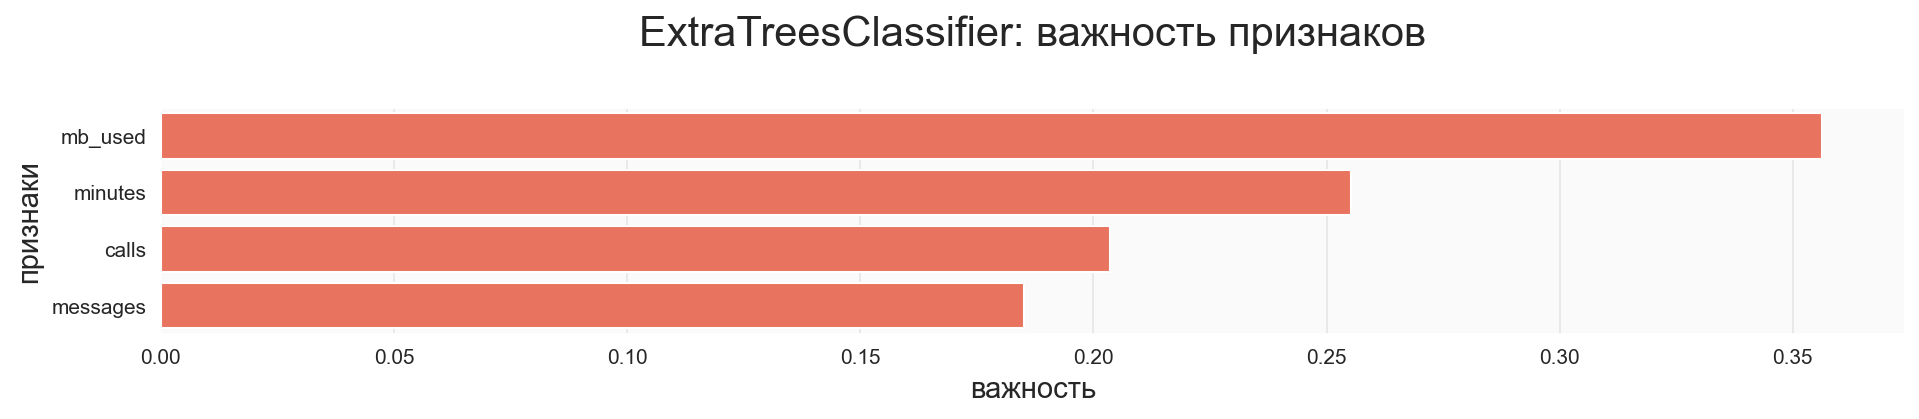

In [22]:
plot_importance('ExtraTreesClassifier', model_ETC)

> Наиболее важным признаком оказалось количество **интернет-трафика** `mb_used`.

> Менее всего пользователи двух тарифов различаются количеством **СМС** `messages`.

## Вывод

### Краткий обзор проведенной работы

1. Изучены данные о поведении клиентов, использующих определенные тарифы мобильного оператора.
1. Подготовлены данные для обучения моделей.
1. Обучены 5 моделей на основе разных алгоритмов классификации и оценено их качество.
1. Проанализированы 2 лучшие из моделей.
1. Предпринята попытка создания новых признаков для повышения качества моделей.

### Результаты анализа

**Чтение и проверка входных данных**

Изучено распределение признаков в зависимости от значения целевой переменной.  
Определен нижний порог "адекватности" метрики `accuracy` для будущей модели.

**Подготовка данных для моделей**

Выделена целевая переменная и признаки.  
Набор данных разделен на обучающую и тестовую выборки. Поскольку при обучении моделей использовалась кроссвалидация, валидационная выборка на данном шаге не создавалась.

**Обучение моделей**

Для моделей созданы пайплайны. В будущем это поможет сделать подход к разработке более стандарным.  
Для каждой модели подготовлена сетка гиперпараметров для их оптимизации с помощью перебора.  
Все данные о моделях объединены в датафрейм для лучшего контроля и сохранения информации, касающейся конкретной модели.  
Выполнен подбор оптимальных гиперпараметров.
Выполнено сравнение результатов моделей сначала на кроссвалидации, затем на тестовой выборке.

**Анализ лучшей модели**

`Accuracy` лучших моделей равны примерно 0.81–0.84. Это ненамного лучше прогнозирования константой, для которой `accuracy` = 0.694. Прирост, скорее всего, объясняется зоной больших значений признаков, где явно преобладают клиенты тарифа "Ультра".

Разработана функция для визуализации важности признаков, использованных моделью.  
Построены таблица и график важности признаков для:
- модели RandomForestClassifier, обученной с использованием оптимальных гиперпараметров;
- модели ExtraTreesClassifier, обученной с использованием оптимальных гиперпараметров.

### Рекомендации и риски
 
Возможно, использование метрики `accuracy` для оценки качества моделей вряд ли является хорошим выбором, учитывая несбалансированность целевых классов (0.306 против 0.694).

Корреляция признаков с целевой переменной низкая. Возможно, данных признаков недостаточно для повышения качества моделей.


## The End

ЗЫ  исчю роботу онолитегом или датасатанистом ))